In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

NUM_PIXELS = 256

# Numerically stable implementations
def logsoftmax(x):
    m = torch.max(x, -1, keepdim=True).values
    return x - m - torch.log(torch.exp(x - m).sum(-1, keepdim=True))

def logsumexp(x):
    m = x.max(-1).values
    return m + torch.log(torch.exp(x - m[...,None]).sum(-1))

class ImageTransformer(nn.Module):
    """ImageTransformer with DMOL or categorical distribution."""
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.layers = nn.ModuleList([DecoderLayer(hparams) for _ in range(hparams.nlayers)])
        self.input_dropout = nn.Dropout(p=hparams.dropout)
        if self.hparams.distr == "dmol": # Discretized mixture of logistic, for ordinal valued inputs
            assert self.hparams.channels == 3, "Only supports 3 channels for DML"
            size = (1, self.hparams.channels)
            self.embedding_conv = nn.Conv2d(1, self.hparams.hidden_size,
                                            kernel_size=size, stride=size)
            # 10 = 1 + 2c + c(c-1)/2; if only 1 channel, then 3 total
            depth = self.hparams.num_mixtures * 10
            self.output_dense = nn.Linear(self.hparams.hidden_size, depth, bias=False)
        elif self.hparams.distr == "cat": # Categorical
            self.embeds = nn.Embedding(NUM_PIXELS * self.hparams.channels, self.hparams.hidden_size)
            self.output_dense = nn.Linear(self.hparams.hidden_size, NUM_PIXELS, bias=True)
        else:
            raise ValueError("Only dmol or categorical distributions")

    # TODO: can probably cache this computation. (Be wary of shapes for train vs. predict)
    def add_timing_signal(self, X, min_timescale=1.0, max_timescale=1.0e4):
        num_dims = len(X.shape) - 2 # 2 corresponds to batch and hidden_size dimensions
        num_timescales = self.hparams.hidden_size // (num_dims * 2)
        log_timescale_increment = np.log(max_timescale / min_timescale) / (num_timescales - 1)
        inv_timescales = min_timescale * torch.exp((torch.arange(num_timescales).float() * -log_timescale_increment))
        inv_timescales = inv_timescales.to(X.device)
        total_signal = torch.zeros_like(X) # Only for debugging purposes
        for dim in range(num_dims):
            length = X.shape[dim + 1] # add 1 to exclude batch dim
            position = torch.arange(length).float().to(X.device)
            scaled_time = position.view(-1, 1) * inv_timescales.view(1, -1)
            signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], 1)
            prepad = dim * 2 * num_timescales
            postpad = self.hparams.hidden_size - (dim + 1) * 2 * num_timescales
            signal = F.pad(signal, (prepad, postpad))
            for _ in range(1 + dim):
                signal = signal.unsqueeze(0)
            for _ in range(num_dims - 1 - dim):
                signal = signal.unsqueeze(-2)
            X += signal
            total_signal += signal
        return X

    def shift_and_pad_(self, X):
        # Shift inputs over by 1 and pad
        shape = X.shape
        X = X.view(shape[0], shape[1] * shape[2], shape[3])
        X = X[:,:-1,:]
        X = F.pad(X, (0, 0, 1, 0)) # Pad second to last dimension
        X = X.view(shape)
        return X

    def forward(self, X, sampling=False):
        # Reshape inputs
        if sampling:
            curr_infer_length = X.shape[1]
            row_size = self.hparams.image_size * self.hparams.channels
            nrows = curr_infer_length // row_size + 1
            X = F.pad(X, (0, nrows * row_size - curr_infer_length))
            X = X.view(X.shape[0], -1, row_size)
        else:
            X = X.permute([0, 2, 3, 1]).contiguous()
            X = X.view(X.shape[0], X.shape[1], X.shape[2] * X.shape[3]) # Flatten channels into width

        # Inputs -> embeddings
        if self.hparams.distr == "dmol":
            # Create a "channel" dimension for the 1x3 convolution
            # (NOTE: can apply a 1x1 convolution and not reshape, this is for consistency)
            X = X.unsqueeze(1)
            X = F.relu(self.embedding_conv(X))
            X = X.permute([0, 2, 3, 1]) # move channels to the end
        elif self.hparams.distr == "cat":
            # Convert to indexes, and use separate embeddings for different channels
            X = (X * (NUM_PIXELS - 1)).long()
            channel_addition = (torch.tensor([0, 1, 2]) * NUM_PIXELS).to(X.device).repeat(X.shape[2] // 3).view(1, 1, -1)
            X += channel_addition
            X = self.embeds(X) * (self.hparams.hidden_size ** 0.5)

        X = self.shift_and_pad_(X)
        X = self.add_timing_signal(X)
        shape = X.shape
        X = X.view(shape[0], -1, shape[3])

        X = self.input_dropout(X)
        for layer in self.layers:
            X = layer(X)
        X = self.layers[-1].preprocess_(X) # NOTE: this is identity (exists to replicate tensorflow code)
        X = self.output_dense(X).view(shape[:3] + (-1,))

        if not sampling and self.hparams.distr == "cat": # Unpack the channels
            X = X.view(X.shape[0], X.shape[1], X.shape[2] // self.hparams.channels, self.hparams.channels, X.shape[3])
            X = X.permute([0, 3, 1, 2, 4])

        return X

    def split_to_dml_params(self, preds, targets=None, sampling=False):
        nm = self.hparams.num_mixtures
        mix_logits, locs, log_scales, coeffs = torch.split(preds, [nm, nm * 3, nm * 3, nm * 3], dim=-1)
        new_shape = preds.shape[:-1] + (3, nm)
        locs = locs.view(new_shape)
        coeffs = torch.tanh(coeffs.view(new_shape))
        log_scales = torch.clamp(log_scales.view(new_shape), min=-7.)
        if not sampling:
            targets = targets.unsqueeze(-1)
            locs1 = locs[...,1,:] + coeffs[...,0,:] * targets[:,0,...]
            locs2 = locs[...,2,:] + coeffs[...,1,:] * targets[:,0,...] + coeffs[...,2,:] * targets[:,1,...]
            locs = torch.stack([locs[...,0,:], locs1, locs2], dim=-2)
            return mix_logits, locs, log_scales
        else:
            return mix_logits, locs, log_scales, coeffs

    # Modified from official PixCNN++ code
    def dml_logp(self, logits, means, log_scales, targets):
        targets = targets.unsqueeze(-1)
        centered_x = targets - means
        inv_stdv = torch.exp(-log_scales)
        plus_in = inv_stdv * (centered_x + 1. / 255.)
        cdf_plus = torch.sigmoid(plus_in)
        min_in = inv_stdv * (centered_x - 1. / 255.)
        cdf_min = torch.sigmoid(min_in)
        log_cdf_plus = plus_in - F.softplus(plus_in)  # log probability for edge case of 0 (before scaling)
        log_one_minus_cdf_min = -F.softplus(min_in)  # log probability for edge case of 255 (before scaling)
        cdf_delta = cdf_plus - cdf_min  # probability for all other cases
        mid_in = inv_stdv * centered_x
        log_pdf_mid = mid_in - log_scales - 2. * F.softplus(
            mid_in)  # log probability in the center of the bin, to be used in extreme cases (not actually used in our code)

        # now select the right output: left edge case, right edge case, normal case, extremely low prob case (doesn't actually happen for us)
        log_probs = torch.where(targets < -0.999, log_cdf_plus, torch.where(targets > 0.999, log_one_minus_cdf_min,
                                                                torch.where(cdf_delta > 1e-5,
                                                                         torch.log(torch.clamp(cdf_delta, min=1e-12)),
                                                                         log_pdf_mid - np.log(127.5))))
        log_probs = log_probs.sum(3) + logsoftmax(logits)
        log_probs = logsumexp(log_probs)
        return log_probs

    # Assumes targets have been rescaled to [-1., 1.]
    def loss(self, preds, targets):
        if self.hparams.distr == "dmol":
            # Assumes 3 channels. Input: [batch_size, height, width, 10 * 10]
            logits, locs, log_scales = self.split_to_dml_params(preds, targets)
            targets = targets.permute([0, 2, 3, 1])
            log_probs = self.dml_logp(logits, locs, log_scales, targets)
            return -log_probs
        elif self.hparams.distr == "cat":
            targets = (targets * (NUM_PIXELS - 1)).long()
            ce = F.cross_entropy(preds.permute(0, 4, 1, 2, 3), targets, reduction='none')
            return ce

    def accuracy(self, preds, targets):
        if self.hparams.distr == "cat":
            targets = (targets * (NUM_PIXELS - 1)).long()
            argmax_preds = torch.argmax(preds, dim=-1)
            acc = torch.eq(argmax_preds, targets).float().sum() / np.prod(argmax_preds.shape)
            return acc
        else:
            # Computing accuracy for dmol is more computationally intensive, so we skip it
            return torch.zeros((1,))

    def sample_from_dmol(self, outputs):
        logits, locs, log_scales, coeffs = self.split_to_dml_params(outputs, sampling=True)
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) * (1. - 2 * 1e-5) + 1e-5))
        sel = torch.argmax(logits + gumbel_noise, -1, keepdim=True)
        one_hot = torch.zeros_like(logits).scatter_(-1, sel, 1).unsqueeze(-2)
        locs = (locs * one_hot).sum(-1)
        log_scales = (log_scales * one_hot).sum(-1)
        coeffs = (coeffs * one_hot).sum(-1)
        unif = torch.rand_like(log_scales) * (1. - 2 * 1e-5) + 1e-5
        logistic_noise = torch.log(unif) - torch.log1p(-unif)
        x = locs + torch.exp(log_scales) * logistic_noise
        # NOTE: sampling analogously to pixcnn++, which clamps first, unlike image transformer
        x0 = torch.clamp(x[..., 0], -1., 1.)
        x1 = torch.clamp(x[..., 1] + coeffs[..., 0] * x0, -1., 1.)
        x2 = torch.clamp(x[..., 2] + coeffs[..., 1] * x0 + coeffs[..., 2] * x1, -1., 1.)
        x = torch.stack([x0, x1, x2], -1)
        return x

    def sample_from_cat(self, logits, argmax=False):
        if argmax:
            sel = torch.argmax(logits, -1, keepdim=False).float() / 255.
        else:
            gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) * (1. - 2 * 1e-5) + 1e-5))
            sel = torch.argmax(logits + gumbel_noise, -1, keepdim=False).float() / 255.
        return sel

    def sample(self, n, device, argmax=False):
        total_len = (self.hparams.image_size ** 2)
        if self.hparams.distr == "cat":
            total_len *= self.hparams.channels
        samples = torch.zeros((n, 3)).to(device)
        for curr_infer_length in tqdm(range(total_len)):
            outputs = self.forward(samples, sampling=True)
            outputs = outputs.view(n, -1, outputs.shape[-1])[:,curr_infer_length:curr_infer_length+1,:]
            if self.hparams.distr == "dmol":
                x = self.sample_from_dmol(outputs).squeeze()
            elif self.hparams.distr == "cat":
                x = self.sample_from_cat(outputs, argmax=argmax)
            if curr_infer_length == 0:
                samples = x
            else:
                samples = torch.cat([samples, x], 1)
        samples = samples.view(n, self.hparams.image_size, self.hparams.image_size, self.hparams.channels)
        samples = samples.permute(0, 3, 1, 2)
        return samples

    def sample_from_preds(self, preds, argmax=False):
        if self.hparams.distr == "dmol":
            samples = self.sample_from_dmol(preds)
            samples = samples.permute(0, 3, 1, 2)
        elif self.hparams.distr == "cat":
            samples = self.sample_from_cat(preds, argmax=argmax)
        return samples


class DecoderLayer(nn.Module):
    """Implements a single layer of an unconditional ImageTransformer"""
    def __init__(self, hparams):
        super().__init__()
        self.attn = Attn(hparams)
        self.hparams = hparams
        self.dropout = nn.Dropout(p=hparams.dropout)
        self.layernorm_attn = nn.LayerNorm([self.hparams.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hparams.hidden_size], eps=1e-6, elementwise_affine=True)
        self.ffn = nn.Sequential(nn.Linear(self.hparams.hidden_size, self.hparams.filter_size, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(self.hparams.filter_size, self.hparams.hidden_size, bias=True))

    def preprocess_(self, X):
        return X

    # Takes care of the "postprocessing" from tensorflow code with the layernorm and dropout
    def forward(self, X):
        X = self.preprocess_(X)
        y = self.attn(X)
        X = self.layernorm_attn(self.dropout(y) + X)
        y = self.ffn(self.preprocess_(X))
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X

class Attn(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.kd = self.hparams.total_key_depth or self.hparams.hidden_size
        self.vd = self.hparams.total_value_depth or self.hparams.hidden_size
        self.q_dense = nn.Linear(self.hparams.hidden_size, self.kd, bias=False)
        self.k_dense = nn.Linear(self.hparams.hidden_size, self.kd, bias=False)
        self.v_dense = nn.Linear(self.hparams.hidden_size, self.vd, bias=False)
        self.output_dense = nn.Linear(self.vd, self.hparams.hidden_size, bias=False)
        assert self.kd % self.hparams.num_heads == 0
        assert self.vd % self.hparams.num_heads == 0

    def dot_product_attention(self, q, k, v, bias=None):
        logits = torch.einsum("...kd,...qd->...qk", k, q)
        if bias is not None:
            logits += bias
        weights = F.softmax(logits, dim=-1)
        return weights @ v

    def forward(self, X):
        q = self.q_dense(X)
        k = self.k_dense(X)
        v = self.v_dense(X)
        # Split to shape [batch_size, num_heads, len, depth / num_heads]
        q = q.view(q.shape[:-1] + (self.hparams.num_heads, self.kd // self.hparams.num_heads)).permute([0, 2, 1, 3])
        k = k.view(k.shape[:-1] + (self.hparams.num_heads, self.kd // self.hparams.num_heads)).permute([0, 2, 1, 3])
        v = v.view(v.shape[:-1] + (self.hparams.num_heads, self.vd // self.hparams.num_heads)).permute([0, 2, 1, 3])
        q *= (self.kd // self.hparams.num_heads) ** (-0.5)

        if self.hparams.attn_type == "global":
            bias = -1e9 * torch.triu(torch.ones(X.shape[1], X.shape[1]), 1).to(X.device)
            result = self.dot_product_attention(q, k, v, bias=bias)
        elif self.hparams.attn_type == "local_1d":
            len = X.shape[1]
            blen = self.hparams.block_length
            pad = (0, 0, 0, (-len) % self.hparams.block_length) # Append to multiple of block length
            q = F.pad(q, pad)
            k = F.pad(k, pad)
            v = F.pad(v, pad)

            bias = -1e9 * torch.triu(torch.ones(blen, blen), 1).to(X.device)
            first_output = self.dot_product_attention(
                q[:,:,:blen,:], k[:,:,:blen,:], v[:,:,:blen,:], bias=bias)

            if q.shape[2] > blen:
                q = q.view(q.shape[0], q.shape[1], -1, blen, q.shape[3])
                k = k.view(k.shape[0], k.shape[1], -1, blen, k.shape[3])
                v = v.view(v.shape[0], v.shape[1], -1, blen, v.shape[3])
                local_k = torch.cat([k[:,:,:-1], k[:,:,1:]], 3) # [batch, nheads, (nblocks - 1), blen * 2, depth]
                local_v = torch.cat([v[:,:,:-1], v[:,:,1:]], 3)
                tail_q = q[:,:,1:]
                bias = -1e9 * torch.triu(torch.ones(blen, 2 * blen), blen + 1).to(X.device)
                tail_output = self.dot_product_attention(tail_q, local_k, local_v, bias=bias)
                tail_output = tail_output.view(tail_output.shape[0], tail_output.shape[1], -1, tail_output.shape[4])
                result = torch.cat([first_output, tail_output], 2)
                result = result[:,:,:X.shape[1],:]
            else:
                result = first_output[:,:,:X.shape[1],:]

        result = result.permute([0, 2, 1, 3]).contiguous()
        result = result.view(result.shape[0:2] + (-1,))
        result = self.output_dense(result)
        return result

In [2]:
import argparse
import torch
import sys
import time
import os
import logging
import yaml
import shutil
import numpy as np
import tensorboardX
import torch.optim as optim
import torchvision
from image_transformer import ImageTransformer
import matplotlib
import itertools
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchviz import make_dot
from tqdm import tqdm
import torch.nn as nn

matplotlib.use('Agg')
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

def parse_args_and_config():
    """
    :return args, config: namespace objects that stores information in args and config files.
    """
    parser = argparse.ArgumentParser(description=globals()['__doc__'])

    parser.add_argument('--config', type=str, default='transformer_dmol.yml', help='Path to the config file')
    parser.add_argument('--doc', type=str, default='0', help='A string for documentation purpose')
    parser.add_argument('--verbose', type=str, default='info', help='Verbose level: info | debug | warning | critical')
    parser.add_argument('--sample', action='store_true', help='Sample at train time')

    args = parser.parse_args()
    args.log = os.path.join('transformer_logs', args.doc)
    # parse config file
    with open(os.path.join('configs', args.config), 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    new_config = dict2namespace({**config, **vars(args)})

    if os.path.exists(args.log):
        shutil.rmtree(args.log)

    os.makedirs(args.log)

    with open(os.path.join(args.log, 'config.yml'), 'w') as f:
        yaml.dump(new_config, f, default_flow_style=False)

    # setup logger
    level = getattr(logging, args.verbose.upper(), None)
    if not isinstance(level, int):
        raise ValueError('level {} not supported'.format(args.verbose))

    handler1 = logging.StreamHandler()
    handler2 = logging.FileHandler(os.path.join(args.log, 'stdout.txt'))
    formatter = logging.Formatter('%(levelname)s - %(filename)s - %(asctime)s - %(message)s')
    handler1.setFormatter(formatter)
    handler2.setFormatter(formatter)
    logger = logging.getLogger()
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    logger.setLevel(level)

    # add device information to args
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    logging.info("Using device: {}".format(device))
    new_config.device = device

    # set random seed
    torch.manual_seed(new_config.seed)
    torch.cuda.manual_seed_all(new_config.seed)
    np.random.seed(new_config.seed)
    logging.info("Run name: {}".format(args.doc))

    return args, new_config

def get_lr(step, config):
    warmup_steps = config.optim.warmup
    lr_base = config.optim.lr * 0.002 # for Adam correction
    ret = 5000. * config.model.hidden_size ** (-0.5) * \
          np.min([(step + 1) * warmup_steps ** (-1.5), (step + 1) ** (-0.5)])
    return ret * lr_base

In [3]:
import argparse
args = argparse.Namespace()

In [4]:
args.channels = 3
args.image_size = 32
args.hidden_size = 512
args.nlayers = 12
args.num_heads = 4
args.total_key_depth = 0
args.total_value_depth = 0
args.attn_type = 'local_1d'
args.distr= 'cat'
args.filter_size = 2048
args.dropout = 0.3
args.block_length = 256
args.initializer_gain = 0.2


#args, config = parse_args_and_config()
#tb_logger = tensorboardX.SummaryWriter(log_dir=os.path.join('transformer_logs', args.doc))

'''
if config.model.distr == "dmol":
        # Scale size and rescale data to [-1, 1]
    transform = transforms.Compose([
            transforms.Resize(config.model.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        ])
        '''

#else:

image_size = 32 
channels = 3 
transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

# CIFAR-10のテストデータだけを取り出している（はず）
dataset_test = datasets.CIFAR10('datasets/transformer', transform=transform, download=True, train=False)
loader = DataLoader(dataset_test, batch_size=4, shuffle=True, num_workers=4)

# Image Transformer本体の準備
input_dim = image_size ** 2 * channels
device = torch.device('cpu')
model = ImageTransformer(args).to(device)
# 訓練した重みを格納
path = './transformer_logs/run_name/model.pth'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint)

Files already downloaded and verified


<All keys matched successfully>

In [5]:
# 猫の画像だけ取り出す
cat_test_images = []
iterator = iter(dataset_test)
while(1):
    try:
        temp_tuple = next(iterator) 
    except:
        break 
    if temp_tuple[1] == 3:
        cat_test_images.append(torch.unsqueeze(temp_tuple[0], axis=0))
    

In [6]:
# start_index から バッチサイズ分だけ画像を取り出す
start_index = 100
temp_input = cat_test_images[0]
for i in range(start_index, start_index + 3, 1):
    temp = cat_test_images[i+1]

    temp_input = torch.cat((temp_input, temp), 0)

In [8]:
# テストデータセットのバッチを入力して、それぞれの画像を復元した結果がtransformed_output

#おそらく一番奥の256次元ベクトルでどの画素値であるかの分類を行なっている。
#つまり、総数4*3*32*32個のチャンネル/ピクセルにおいて256クラスの分類を行う。
temp_output = model(temp_input)
print(temp_output.shape)

torch.Size([4, 3, 32, 32, 256])


In [9]:
# 256次元ベクトルで要素が最大のインデックスを選ぶ操作。
#　つまり、(0, 1, 0, ....0)という256次元ベクトルの第２要素が最大値のとき、このベクトルをインデックスを表すスカラー、
# つまり1に変換。
#　それを総数4*3*32*32個のチャンネル/ピクセルすべてでやるから結果としてtorch.Size([4, 3, 32, 32])のテンソル が得られる。
transformed_output = torch.argmax(temp_output, axis=4)
print(transformed_output.shape)

torch.Size([4, 3, 32, 32])


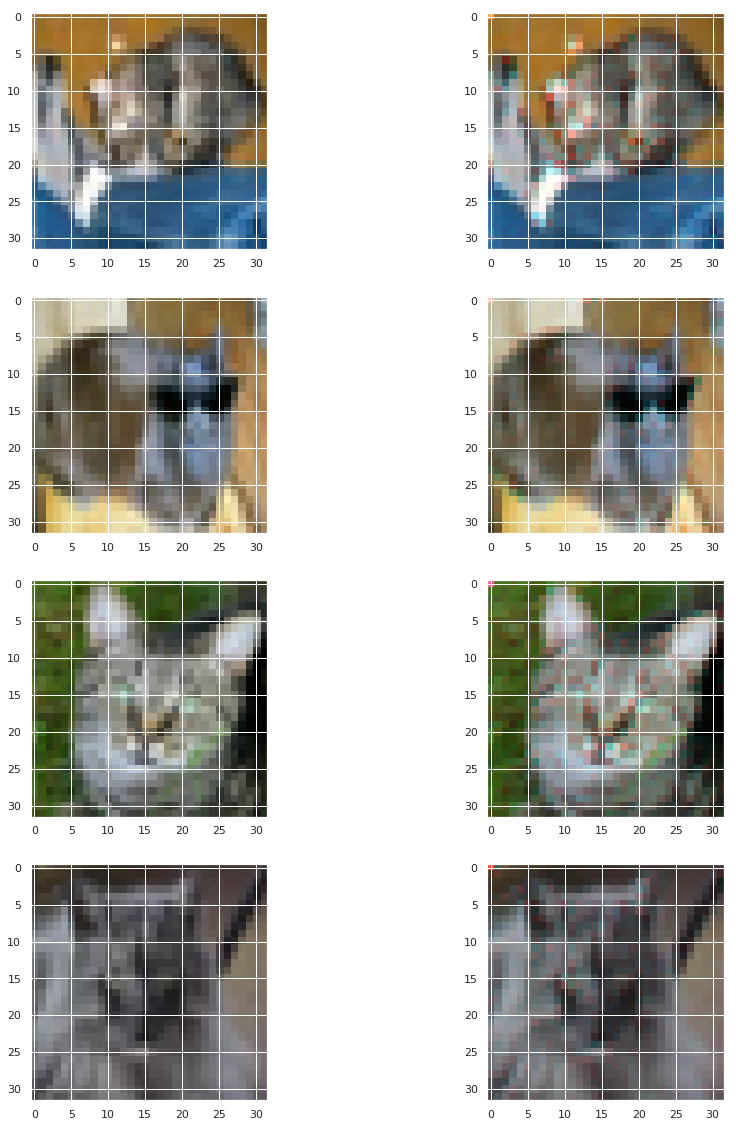

In [8]:
import matplotlib.pyplot as plt 

%matplotlib inline

plt.figure(figsize=(15, 20))

#入力(左側)、出力(右側)の比較。
#若干違うのがわかる。
for i in range(temp_input.shape[0]):
    #img = img_batch[i]
    img = np.transpose(temp_input[i], [1, 2, 0])
    #img = (img.numpy() * 255).astype(np.uint8)
    plt.subplot(temp_input.shape[0], 2, 2*i + 1)
    plt.imshow(img)
    
    img = np.transpose(transformed_output[i].detach(), [1, 2, 0])
   # img = (img.numpy() * 255).astype(np.uint8)
    plt.subplot(temp_output.shape[0], 2, 2*i + 2)
    plt.imshow(img)

    
